In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt # matplotlib库用于绘图展示
# 魔法指令，直接展示图，Jupyter notebook特有
%matplotlib inline

# 第一步
主要实现对于图像灰度化显示。

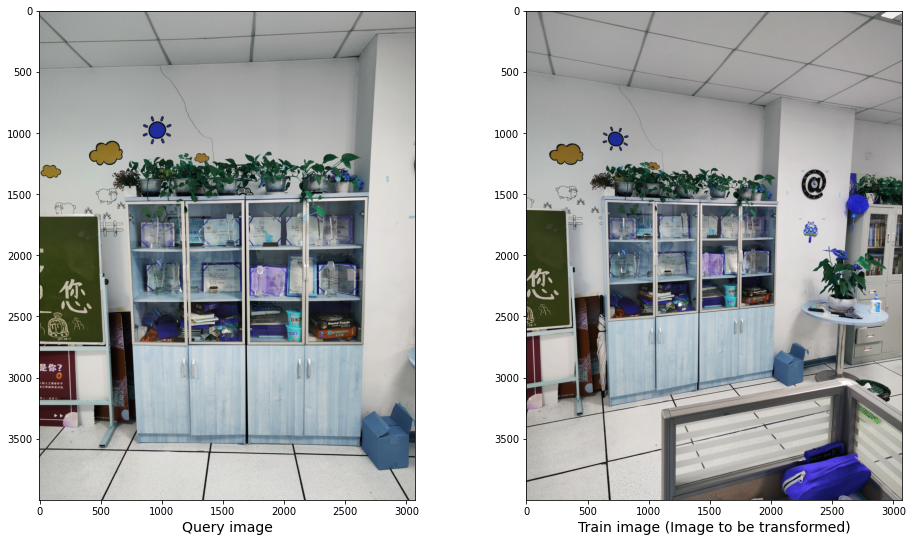

In [82]:
trainImg = cv2.imread('img.png')[:4000,:,:]
trainImg_gray = cv2.cvtColor(trainImg, cv2.COLOR_RGB2GRAY)

queryImg = cv2.imread('img_2.png')[:4000,:,:]

queryImg_gray = cv2.cvtColor(queryImg, cv2.COLOR_RGB2GRAY)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16,9))
ax1.imshow(queryImg, cmap="gray")
ax1.set_xlabel("Query image", fontsize=14)

ax2.imshow(trainImg, cmap="gray")
ax2.set_xlabel("Train image (Image to be transformed)", fontsize=14)

plt.show()

# 第二步
构建ORB特征提取
计算图像关键点和描述符

In [83]:
def detectAndDescribe(image):
    """
    计算特征点
    """
    # descriptor = cv2.BRISK_create()
    descriptor = cv2.ORB_create()
    # 返回关键点集合
    # 返回描述符
    (kps, features) = descriptor.detectAndCompute(image, None)
    return (kps, features)

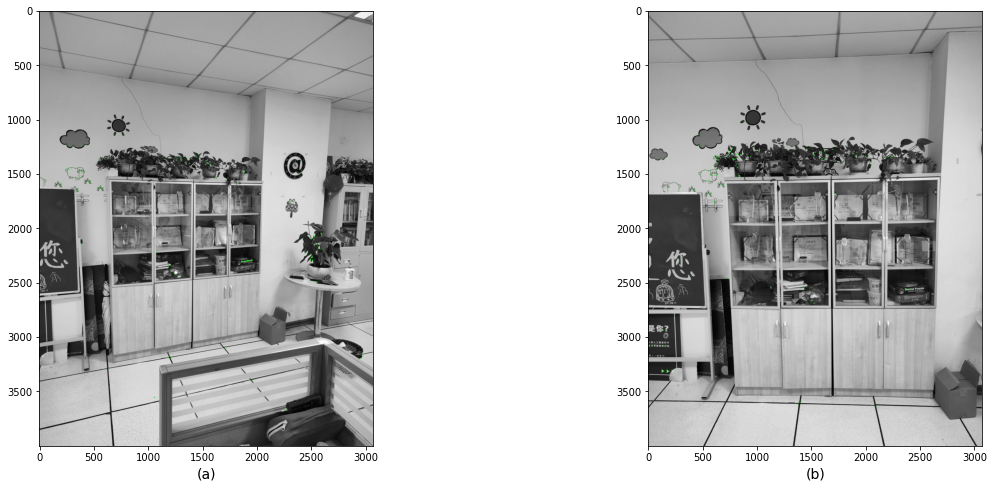

In [84]:
kpsA, featuresA = detectAndDescribe(trainImg_gray)
kpsB, featuresB = detectAndDescribe(queryImg_gray)
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(trainImg_gray,kpsA,None,color=(0,255,0)))
ax1.set_xlabel("(a)", fontsize=14)
ax2.imshow(cv2.drawKeypoints(queryImg_gray,kpsB,None,color=(0,255,0)))
ax2.set_xlabel("(b)", fontsize=14)

plt.show()

# 特征匹配

利用汉明距离计算相似特征点之间的距离
最后对特征点进行排序，按照从小到大排序

In [85]:
def createMatcher():
    # crossCheck表示两个特征点相互匹配
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    return bf

def matchKeyPointsBF(featuresA, featuresB):
    bf = createMatcher()

    # 匹配特征点
    best_matches = bf.match(featuresA,featuresB)

    # 排序，按距离从小到大排序
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("Raw matches (Brute force):", len(rawMatches))
    return rawMatches


Raw matches (Brute force): 169


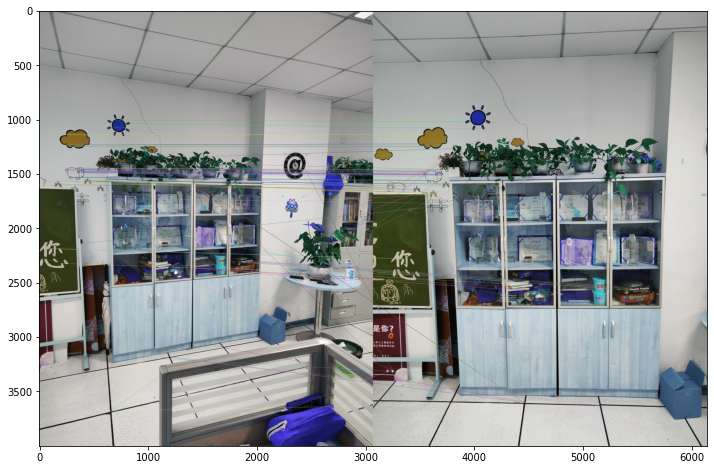

In [86]:
fig = plt.figure(figsize=(20,8))

matches = matchKeyPointsBF(featuresA, featuresB)
# 前100个特征画出来
# 不画出单独的点。
img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,matches[:100],
                       None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(img3)
plt.show()

# 计算并优化特征匹配，最后输出转换函数

In [100]:
def getHomography(kpsA, kpsB, matches, reprojThresh):
    # convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])

    if len(matches) > 4:

        # construct the two sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])

        # estimate the homography between the sets of points
        # ransacReprojThreshold 重投影最大误差
        (H, _) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
            reprojThresh)

        return H
    else:
        return None

In [101]:
H = getHomography(kpsA, kpsB, matches, reprojThresh=4)
print(H)

[[ 8.80473292e-01  2.44119186e-02  2.05538340e+02]
 [-2.72808741e-01  1.07828884e+00 -5.06857065e+01]
 [-1.42596715e-04  8.78451232e-06  1.00000000e+00]]


# 全景图拼接
利用透视变换拼接两张图像。

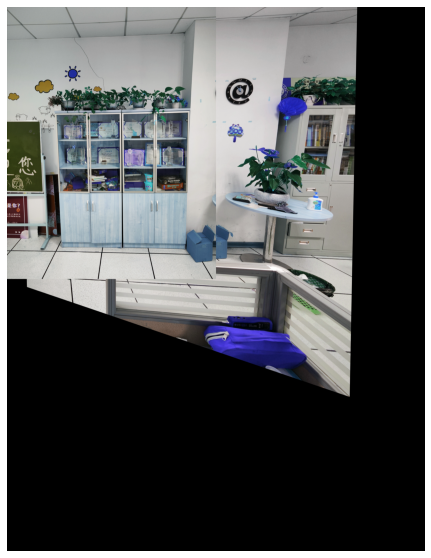

In [96]:
# 进行全景图透视变换
width = trainImg.shape[1] + queryImg.shape[1]
height = trainImg.shape[0] + queryImg.shape[0]

result = cv2.warpPerspective(trainImg, H, (width, height))
result[0:queryImg.shape[0], 0:queryImg.shape[1]] = queryImg

plt.figure(figsize=(20,10))
plt.imshow(result)

plt.axis('off')
plt.show()

# 定位图片位置
最后根据图像的位置，自动将需要的内容提取出来。

24859411.0 0 0 5149 5735


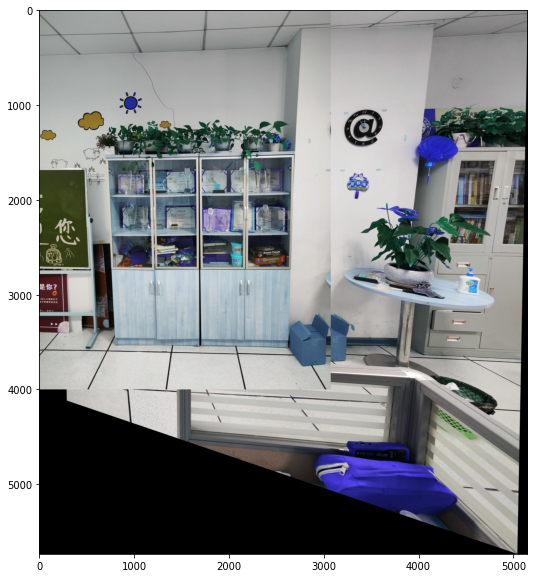

In [97]:
# 自动查找图片位置
gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

#根据二值化对图像位置进行查找
cnts,_ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for cnt in cnts:
    area = cv2.contourArea(cnt)
    if area>100000:
        (x, y, w, h) = cv2.boundingRect(cnt)
        print(area,x,y,w,h)
        result = result[y:y + h, x:x + w]
        plt.figure(figsize=(20,10))
        plt.imshow(result)
        break